In this lab, you should try to implement some of the techniques discussed in the lecture.
Here is a list of reasonable tasks.

Must implement:
 * Log-loss
 
Easy:
 * L1 and L2 regularization (you can choose one)
 * momentum, Nesterov's momentum (you can choose one)

Medium difficulty:
 * Adagrad, RMSProp (you can shoose one) - not much harder than momentum, really
 * dropout

Hard (and time-consuming):
 * batch-normalization

Try to test your network to see if these changes improve accuracy. They improve accuracy much more if you increase the layer size, and if you add more layers, say 1 or 2.

In [7]:
import random
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import timeit

In [8]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

In [11]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz


Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [12]:
mnist.train.images.shape

(55000, 784)

Epoch 0: 0.101

 Epoch 1 complete

 Epoch 2 complete

 Epoch 3 complete

 Epoch 4 complete

 Epoch 5 complete

 Epoch 6 complete

 Epoch 7 complete

 Epoch 8 complete

 Epoch 9 complete

 Epoch 10: 0.1135


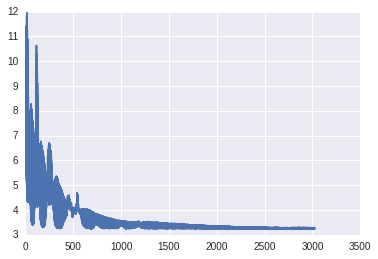

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# apply regularization

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

class Layer(object):
    def descent(self, lr, *args, **kwargs):
        pass

    def get_weigths(self):
        return []

    def get_gradients(self):
        return []
    
class Linear(Layer):
    def __init__(self, ins, outs):
        self.w = np.random.normal(scale=(1.0  / (ins + outs)), size=[ins, outs])
        self.b = np.random.normal(scale=0.1, size=[outs])

    def forward(self, input):
        # input.shape = (batch_size, inp_width)
        # w.shape = (inp_width, outp_width)
        # b.shape = (outp_width)
        return np.dot(input, self.w) + self.b

    def backward(self, orig_input, orig_output, output_gradient):
        # gp ~ bs x in_w
        # g ~ bs x out_w
        # Lg ~ bs x out_w
        gp = orig_input
        f = orig_output
        Lf = output_gradient

        # gp.T ~ in_w x bs
        # Lf = bs x out_w
        # 
        Lw = np.dot(gp.T, Lf)
        self.grad_w = Lw
        self.grad_b = np.sum(Lf.T, axis=1)

        # Lf ~ bs x out_w
        # w.T ~ out_w x in_w
        Lgp = np.dot(Lf, self.w.T)
        return Lgp

    def descent(self, lr, l1_reg_lambda=0.0):
        self.w -= np.sign(self.w) * l1_reg_lambda
        self.w -= lr * self.grad_w
        self.b -= lr * self.grad_b

    def get_gradients(self):
        return [self.grad_w, self.grad_b]

    def get_weigths(self):
        return [self.w, self.b]

class SepLogRegLoss(Layer):
    def setup(self, exp_input):
        self.exp_input = exp_input

    def forward(self, input):
        # g ~ bs x cls
        # y ~ bs x cls
        g = input
        y = self.exp_input

        sep_losses = -y*np.log(g) - (1.-y)*np.log(1.-g)
        per_case_loss = np.sum(sep_losses, axis=1)
        loss = np.average(per_case_loss)
        return loss

    def backward(self, orig_input, orig_output, output_gradient):
        bs = orig_input.shape[0]
        y = self.exp_input
        g = orig_input
        return -1./bs * (y / g - (1.-y) / (1.-g))

class Sigmoid(Layer):
    def forward(self, input):
        # input.shape = (batch_size, inp_width)
        # w.shape = (inp_width, outp_width)
        # b.shape = (outp_width)
        return sigmoid(input)

    def backward(self, orig_input, orig_output, output_gradient):
        # gp ~ bs x in_w
        # g ~ bs x out_w
        # Lg ~ bs x out_w
        g = orig_output
        Lg = output_gradient
        Lf = Lg * g * (1.0 - g)
        return Lf

class SepLogRegLoss(Layer):
    def setup(self, exp_input):
        self.exp_input = exp_input

    def forward(self, input):
        # g ~ bs x cls
        # y ~ bs x cls
        g = input
        y = self.exp_input

        sep_losses = -y*np.log(g) - (1.-y)*np.log(1.-g)
        per_case_loss = np.sum(sep_losses, axis=1)
        loss = np.average(per_case_loss)
        return loss

    def backward(self, orig_input, orig_output, output_gradient):
        bs = orig_input.shape[0]
        y = self.exp_input
        g = orig_input
        return -1./bs * (y / g - (1.-y) / (1.-g))


class Net(object):
    def __init__(self, layers):
        self.layers = layers

    def forward_backward(self, input):
        inp = input
        inouts = []
        for l in self.layers:
            out = l.forward(inp)
            inouts.append((inp, out))
            inp = out

        grad = 1.
        for l, (oinp, oout) in reversed(zip(self.layers, inouts)):
            grad = l.backward(oinp, oout, grad)

        return inouts

    def grad_descent(self, lr):
        for l in self.layers:
            l.descent(lr, l1_reg_lambda = 0.1)

class Network(object):
    def __init__(self, sizes):
        self.loss_layer = SepLogRegLoss()
        
        net = []
        for ins, outs in zip(sizes[:-1], sizes[1:]):
            net += [
                Linear(ins, outs),
                Sigmoid()
            ]
        net += [self.loss_layer]
            
        self.net = Net(net)
        self.losses = []

    def feedforward(self, a):
        return a

    def run_minibach(self, mini_batch):
        xs = mini_batch[0].reshape(-1, 784)
        ys = mini_batch[1].reshape(-1, 10)
        assert xs.shape[0] == ys.shape[0]
        self.loss_layer.setup(ys)
        return self.net.forward_backward(xs)

    def numeric_gradient_check(self, mini_batch, eps=1e-6):
        results = self.run_minibach(mini_batch)
        base_loss = results[-1][1]

        print 'Base loss', base_loss
        print 'Changing single weigth'
        l=1
        wt=1
        ind = 9
        lw = self.net.layers[l].get_weigths()[wt]
        grad_lw = self.net.layers[l].get_gradients()[wt]
        org_grad = grad_lw.flat[ind]
        orig = lw.flat[ind]
        lw.flat[ind] += eps
        results = self.run_minibach(mini_batch)
        lw0_loss = results[-1][1]
        print 'lw[ind] change loss', base_loss, 'delta', base_loss - lw0_loss
        ngrad = (lw0_loss - base_loss) / eps
        print 'lw[ind] grad', ngrad, 'analitical grad', org_grad
        lw.flat[ind] = orig

        results = self.run_minibach(mini_batch)
        print 'After revert', results[-1][1]

        fig, axs = plt.subplots(len(self.net.layers), 2, figsize=(10, 10))
        diffs = []
        for row, l in enumerate(self.net.layers):
            for col, w in enumerate(l.get_gradients()):
                for i in xrange(len(w.flat)):
                    diffs.append(w.flat[i])
                axs[row,col].hist(list(w.flat), 50)

        num_diffs = []
        for l in self.net.layers:
            for w in l.get_weigths():
                for i in xrange(len(w.flat)):
                    orig = w.flat[i]
                    w.flat[i] += eps
                    results = self.run_minibach(mini_batch)
                    new_loss = results[-1][1]
                    num_diff = (new_loss - base_loss) / eps
                    num_diffs.append(num_diff)
                    w.flat[i] = orig

        num_diffs = np.array(num_diffs)
        diffs = np.array(diffs)
        error = np.abs(num_diffs-diffs)
        print np.min(error), np.average(error), np.max(error)

    def update_mini_batch(self, mini_batch, lr):
        outputs = self.run_minibach(mini_batch)
        self.losses.append(outputs[-1][1])
        self.net.grad_descent(lr)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        outputs = self.run_minibach(test_data)
        net_output = outputs[-1][0]
        test_results = [(np.argmax(net_output[i]),
                         np.argmax(test_data[1][i]))
                        for i in range(len(test_data[0]))]
        #print test_results
        return sum(int(x == y) for (x, y) in test_results)

    def SGD(self, training_data, epochs, mini_batch_size, lr, test_data=None):
        self.losses = []
        train_size = training_data.images.shape[0]
        if test_data:
            test_size = test_data.images.shape[0]
        for j in xrange(epochs):
            for k in range(train_size/mini_batch_size):
                self.update_mini_batch(training_data.next_batch(mini_batch_size), lr)
            if test_data and j % 10 == 0:
                res = np.mean([self.evaluate(test_data.next_batch(mini_batch_size)) for k in range(test_size/mini_batch_size)])/mini_batch_size
                print "Epoch {0}: {1}".format(j, res),
            else:
                print "Epoch {0} complete".format(j),
        plt.plot(self.losses)


network = Network([784,30,10])
# network.numeric_gradient_check(mnist.train.next_batch(50))
network.SGD(mnist.train,epochs=11,mini_batch_size=200,lr=0.01,test_data=mnist.test)